# Additional test to run different options

* [Selflink](https://colab.research.google.com/drive/18yocNI6P7xIFq3MlYJ_ET-SzYMUv9uPd)
* [This Coral TPU project](https://github.com/foobar167/junkyard/tree/master/coral_tpu)

In [ ]:
import os
import math
import json
import shutil
import zipfile
import tarfile
import platform

from PIL import Image
# from IPython.display import display
from matplotlib import pyplot as plt


def extract(fname):
    """ Extract data from archive file """
    if fname.endswith(".tar.gz") or fname.endswith(".tgz"):
        ref = tarfile.open(fname, mode="r:gz")
    elif fname.endswith(".tar"):
        ref = tarfile.open(fname, mode="r:")
    elif fname.endswith(".tar.bz2") or fname.endswith(".tbz"):
        ref = tarfile.open(fname, mode="r:bz2")
    elif fname.endswith(".zip"):
        ref = zipfile.ZipFile(fname, mode="r")
    ref.extractall()
    ref.close()


def tgz(sdir):
    """ Make *.tgz archive file from source dir """
    sdir = sdir.strip("\\/")  # remove all leading and trailing slashes
    fname = os.path.basename(sdir)
    fname_tgz = fname + ".tgz"
    fname_tar_gz = fname + ".tar.gz"
    archive1 = os.path.join(os.path.dirname(sdir), fname_tgz)
    archive2 = os.path.join(os.path.dirname(sdir), fname_tar_gz)
    # Delete dir or file if exists
    if os.path.exists(archive1) and os.path.isdir(archive1):
        shutil.rmtree(archive1, ignore_errors=False)
    elif os.path.exists(archive1) and os.path.isfile(archive1):
        os.remove(archive1)
    # Make *.tag.gz file
    with tarfile.open(fname_tar_gz, "w:gz") as tar:
        tar.add(sdir, arcname=fname)
    # Reaneme *.tar.gz to *.tgz
    os.rename(archive2, archive1)


EXT = (".jpg", ".jpeg", ".png", ".gif")  # valid image file extensions


def separator(info=""):
    """ Separator string with information """
    sep1 = "-"
    sep2 = " "
    sep_length = 70  # separator length
    l1 = (sep_length - len(info)) // 2 - len(sep2)  # number of dashes
    if len(info) == 0:
        s = sep1 * sep_length
        return f"{s}"
    elif l1 <= 0:
        return info
    else:
        l2 = (sep_length - len(info)) % 2  # 0 or 1 extra space
        s1 = sep1 * l1
        s2 = info + " " * l2
        return f"{s1}{sep2}{s2}{sep2}{s1}"


def get_image_names(path):
    """ Get all image names in a directory """
    names = []
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            names.append(f)
    return names


def get_image_names2(path):
    """ Get all image names in a directory and
        return the list of (label, name) """
    dataset = []  # list of (label, name)
    classes = {}  # dict of classes
    for root, dirs, files in os.walk(path, topdown=True):
        for name in files:
            if name.lower().endswith(EXT):
                label = os.path.basename(root)
                name = os.path.join(root, name)
                dataset.append((int(label), name))
                classes[label] = label
    return dataset, classes


def get_images(path):
    """ Get all images in a directory """
    images = {}
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            images[f] = Image.open(os.path.join(path, f)).convert("RGB")
    return images


def get_images2(lst):
    """ Get all images from the list (label, name) and
        return dictoonary of images """
    images = {}
    for label, name in lst:
        if name.lower().endswith(EXT):
            images[name] = Image.open(name).convert("RGB")
    return images


# def show(images, cmap="viridis"):
#     """ Show images with matplotlib. Default color map is "viridis" """
#     for key, value in images.items():
#         value = value.resize((100, 100))
#         display(value)


def show(images, cmap="viridis"):
    """ Show images with matplotlib. Default color map is "viridis" """
    fig = plt.figure(figsize=(12, 8))  # create figure
    l = len(images)
    rows = math.floor(math.sqrt(l))
    cols = math.ceil(l / rows)
    for i, (key, value) in enumerate(images.items(), 1):
        fig.add_subplot(rows, cols, i)  # add a subplot
        plt.imshow(value, cmap=cmap); plt.axis("off"); plt.title(key)
    plt.show()


def load_labels(idx=1):
    """ Get ImageNet dataset labels from URL """
    url = "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/data/imagenet_class_index.json"
    name = os.path.basename(url)
    if not os.path.exists(name):
        output = os.system(f"wget {url} -O {name}")
        if output != 0:
            print(f"Error when downloading URL: {url}")
            return None
    CLASS_INDEX = json.load(open(name))
    labels = []
    for i in range(len(CLASS_INDEX)):
        # CLASS_INDEX example: "753": ["n04040759", "radiator"]
        labels.append(CLASS_INDEX[str(i)][idx])
    return labels


_INFO = {
    "Linux": "lscpu | grep 'Model name:'",
    "Windows": "wmic cpu get name, numberofcores",
}[platform.system()]


print(separator("CPU info"))
print(os.popen(cmd=_INFO).read())  # get info about the hardware (CPU)

------------------------------ CPU info ------------------------------
Model name:                         Intel(R) Xeon(R) CPU @ 2.20GHz



[Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

parrot.jpg
human.jpg
cat.jpg
panda.jpg


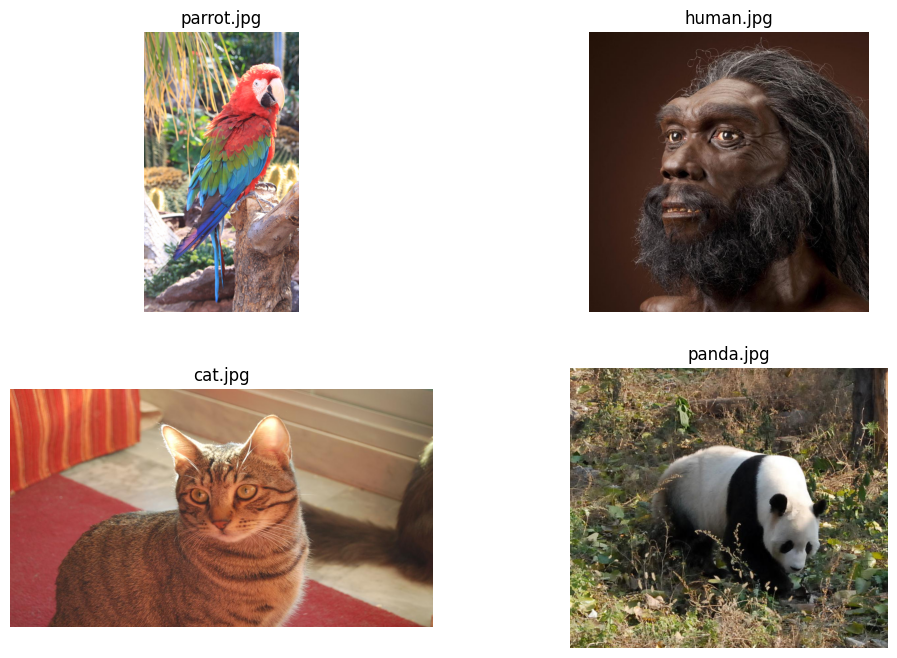

In [ ]:
# Import necessary libraries
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.applications as apps

from IPython.display import display
# from tensorflow.keras.saving import save_model, load_model
from tensorflow.keras.models import save_model, load_model


# Create "temp" directory and make it the current dir
temp_dir = "temp"
this_dir = os.path.dirname(os.path.realpath("__file__"))  # path to the current dir
if os.path.basename(this_dir) == temp_dir:  # already in the "temp" directory
    pass
else:
    if not os.path.isdir(temp_dir):  # directory does not exist
        os.makedirs(temp_dir)
    os.chdir(os.path.join(this_dir, temp_dir))  # make path to "temp" dir the current path


# Download test images and show them
urls = {"parrot.jpg": "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/parrot.jpg",
        "cat.jpg":    "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/cat.jpg",
        "panda.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/panda.jpg",
        "human.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/human.jpg",
}
img_paths = []
for name, url in urls.items():
    output = os.system(f"wget {url} -O {name}")
    if output == 0:
        img_paths.append(name)
    else:
        print(f"Error when downloading URL: {url}")
print("\n".join(get_image_names(".")))  # print image names
show(get_images("."))  # show images


# Set constants
BATCH_SIZE = 100
IMAGE_SHAPE = (224, 224, 3)  # do not change it
IMAGE_SHAPE2 = (299, 299, 3)  # do not change it
RESIZE_METHOD = Image.BILINEAR
RESIZE_METHOD2 = tf.image.ResizeMethod.BILINEAR
BENCHMARK_IMG = "parrot.jpg"
COUNT = 6  # number of runs for benchmark
TOP_K = 3  # get first top results
OPTIMIZER = "rmsprop"
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
METRICS = ["accuracy"]
TEMP_DIR = "."


# MobileNet models dictionary in the format:
#     key: [name, model, api, results]
net = {
    # "MobileNetV1": ["mobilenetv1_1.0_224",  # v[0] filename
    #                 apps.MobileNet(),       # v[1] model architecture
    #                 apps.mobilenet,         # v[2] API
    #                 "model placeholder",    # v[3] model placeholder
    #                 True,                   # v[4] normalize
    #                 IMAGE_SHAPE],           # v[5] im_shape
    # "MobileNetV2": ["mobilenetv2_1.0_224",
    #                 apps.MobileNetV2(),
    #                 apps.mobilenet_v2,
    #                 "model placeholder",
    #                 True,
    #                 IMAGE_SHAPE],
    # "MobileNetV3LargeMin": ["mobilenetv3large_1.0_224",
    #                         apps.MobileNetV3Large(input_shape=IMAGE_SHAPE,
    #                                               minimalistic=True,
    #                                               include_preprocessing=False,),
    #                         apps.mobilenet_v3,
    #                         "model placeholder",
    #                         True,
    #                         IMAGE_SHAPE],
    # "MobileNetV3SmallMin": ["mobilenetv3small_1.0_224",
    #                         apps.MobileNetV3Small(input_shape=IMAGE_SHAPE,
    #                                               minimalistic=True,
    #                                               include_preprocessing=False,),
    #                         apps.mobilenet_v3,
    #                         "model placeholder",
    #                         True,
    #                         IMAGE_SHAPE],
    # "EfficientNetB0": ["efficientnetb0_224",
    #                    apps.EfficientNetB0(),
    #                    apps.efficientnet,
    #                    "model placeholder",
    #                    False,
    #                    IMAGE_SHAPE],
    # "EfficientNetV2B0": ["efficientnetv2b0_224",
    #                      apps.EfficientNetB0(),
    #                      apps.efficientnet_v2,
    #                      "model placeholder",
    #                      False,
    #                      IMAGE_SHAPE],
    # "EfficientNetV2S": ["efficientnetv2s_224",
    #                     apps.EfficientNetB0(),
    #                     apps.efficientnet_v2,
    #                     "model placeholder",
    #                     False,
    #                     IMAGE_SHAPE],
    # "ConvNeXtTiny": ["convnexttiny_224",
    #                  apps.ConvNeXtTiny(),
    #                  apps.convnext,
    #                  "model placeholder",
    #                  False,
    #                  IMAGE_SHAPE],
    # "ConvNeXtBase": ["convnextbase_224",
    #                  apps.ConvNeXtBase(),
    #                  apps.convnext,
    #                  "model placeholder",
    #                  False,
    #                  IMAGE_SHAPE],
    "DenseNet121": ["densenet121_224",
                    apps.DenseNet121(),
                    apps.densenet,
                    "model placeholder",
                    True,
                    IMAGE_SHAPE],
    # "InceptionV3": ["inceptionv3_299",
    #                 apps.InceptionV3(input_shape=IMAGE_SHAPE2),
    #                 apps.inception_v3,
    #                 "model placeholder",
    #                 True,
    #                 IMAGE_SHAPE2],
    # "ResNet50": ["resnet50_224",
    #              apps.ResNet50(),
    #              apps.resnet,
    #              "model placeholder",
    #              False,  # should be False, not True
    #              IMAGE_SHAPE],
    # "ResNet101": ["resnet101_224",
    #               apps.ResNet101(),
    #               apps.resnet,
    #               "model placeholder",
    #               False,  # should be False, not True
    #               IMAGE_SHAPE],
    # "ResNet50V2": ["resnet50v2_224",
    #                apps.ResNet50V2(),
    #                apps.resnet_v2,
    #                "model placeholder",
    #                True,
    #                IMAGE_SHAPE],
    # "ResNet101V2": ["resnet101v2_224",
    #                 apps.ResNet101V2(),
    #                 apps.resnet_v2,
    #                 "model placeholder",
    #                 True,
    #                 IMAGE_SHAPE],
    # "VGG16": ["vgg16_224",
    #           apps.VGG16(),
    #           apps.vgg16,
    #           "model placeholder",
    #           False,  # should be False, not True
    #           IMAGE_SHAPE],
    # "Xception": ["xception_299",
    #              apps.Xception(),
    #              apps.xception,
    #              "model placeholder",
    #              True,
    #              IMAGE_SHAPE2],
}

In [ ]:
def prepare_image(img_path, preprocess_input, im_shape):
    """ Prepare image for the model """
    # interpolation="lanczos" is better than default "nearest"
    img = Image.open(img_path).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.asarray(img)
    img = preprocess_input(img)
    # plt.imshow(img); plt.show()  # show image if necessary
    img = np.expand_dims(img, axis=0)
    return img


def predict(img, model, decode_predictions):
    """ Predict and decode results """
    # Use "model(img)" instead of "model.predict(img)", because
    # this code gets a retracing warning:
    #     "WARNING : tensorflow:5 out of the last 5 calls to..."
    preds = model(img, training=False).numpy()
    results = decode_predictions(preds, top=3)[0]
    # Return list of tuples (description, probability)
    return [(i[1], f"{i[2]:.4f}") for i in results]


# Predict images
for img_path in img_paths:
    # Prepare image and predict
    for k, v in net.items():
        img = prepare_image(img_path, v[2].preprocess_input, v[5])
        v[3] = predict(img, v[1], v[2].decode_predictions)

    # Show predicitons
    print(f"\n" f"Predictions for '{img_path}' image are:")
    for k, v in net.items():
        print(f"{k:12} {v[3]}")


Predictions for 'parrot.jpg' image are:
DenseNet121  [('macaw', '0.9969'), ('bee_eater', '0.0023'), ('lorikeet', '0.0004')]

Predictions for 'cat.jpg' image are:
DenseNet121  [('Egyptian_cat', '0.7609'), ('tabby', '0.1188'), ('tiger_cat', '0.0926')]

Predictions for 'panda.jpg' image are:
DenseNet121  [('giant_panda', '0.9800'), ('Arctic_fox', '0.0100'), ('lesser_panda', '0.0017')]

Predictions for 'human.jpg' image are:
DenseNet121  [('wig', '0.2805'), ('flute', '0.0482'), ('chimpanzee', '0.0480')]


In [ ]:
def save(model, name):
    """ Save model in *.tgz (tar.gz) archive file """
    # Set optimizer, loss and metrics for evaluation and warning supress
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    save_model(model, name)  # save model in a directory
    # tf.saved_model.save(model, path)  # some other API
    tgz(name)  # archive directory in *.tgz file, the same as *.tar.gz


def load(model_path, unpack=True):
    """ Load model from file """
    if unpack:
        extract(model_path + ".tgz")  # extract from "*.tgz" archive
    model = load_model(model_path)  # load model
    return model


for k, v in net.items():
    print(separator(v[0]))
    save(v[1], v[0])  # save model in *.tgz archive

-------------------------- densenet121_224  --------------------------


In [ ]:
# Download imagenet-sample-images dataset
dir_name = "imagenet-sample-images"
if os.path.exists(dir_name) and os.path.isdir(dir_name):
    pass  # already exsists
else:
    !git clone https://github.com/EliSchwartz/imagenet-sample-images

DS_IMAGES = get_images("imagenet-sample-images")
print(f"Number of images: {len(DS_IMAGES)}")

Number of images: 1000


In [ ]:
def representative_dataset(model_path, normalize, im_shape):
    """ Integer quantization requires a representative dataset, i.e. a few
        images from the training dataset, for the conversion to happen.
        This dataset can be a small subset (around ~100-500 samples)
        of the training or validation data. """
    images = []

    # # Use ImageNet-v2 dataset
    # for data in DS.take(150):  # take ~100-500 samples
    #     img = tf.image.resize(data["image"], im_shape[0:2], method=RESIZE_METHOD2)

    # Use imagenet-sample-images
    for name, img in list(DS_IMAGES.items())[:150]:  # take ~100-500 samples
        img = tf.image.resize(img, im_shape[0:2], method=RESIZE_METHOD2)

        img = tf.cast(img, tf.float32)  # convert from uint8 to float32
        if normalize:  # normalize image
            img = img / 127.5 - 1.0
        else:  # don't normalize
            pass
        images.append(img)

    # Return (yield) slices (1,224,224,3) from "images" list
    slices = tf.data.Dataset.from_tensor_slices(images).batch(1)
    for s in slices:
        yield [s]


def tflite_convert(name, norm, im_shape, ext=".tflite", unpack=False, optim=None):
    """ Convert the model to TF Lite """
    # Untar *.tgz file with the model (not necessary in this notebook)
    if unpack:
        extract(name + ".tgz")

    # # Load model from a folder
    # model = load_model(name)  # load model
    # # Set batch as static. Change (None,224,224,3) to (1,224,224,3)
    # model.input.set_shape((1,) + model.input.shape[1:])
    # # Convert the model to TFLite
    # converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Load model from a file name
    converter = tf.lite.TFLiteConverter.from_saved_model(name)

    if optim is None:  # no quantization
        print(separator(f"TF Lite convertion for {name}"))
    # Q1. Dynamic range quantization
    if optim == "dynamic":
        print(separator(f"Dynamic range quantization for {name}"))
        ext = "_dynamic" + ext
        converter.optimizations = [
            tf.lite.Optimize.DEFAULT,  # set the optimization mode
            # size reduction optimization doesn't work for standard model
            tf.lite.Optimize.EXPERIMENTAL_SPARSITY,  # size reduction
        ]
    # Q2. Float16 quantization
    elif optim == "float16":
        print(separator(f"Float16 quantization for {name}"))
        ext = "_float16" + ext
        converter.optimizations = [tf.lite.Optimize.DEFAULT]  # set the optimization mode
        converter.target_spec.supported_types = [tf.float16]  # float16 quantization
    # Q3. Full integer quantization
    elif optim == "int8":
        print(separator(f"Full integer quantization for {name}"))
        ext = "_int8" + ext
        # This enables quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]  # set the optimization mode
        # This sets the representative dataset for quantization
        converter.representative_dataset = lambda: representative_dataset(name, norm, im_shape)
        # This ensures that if any ops can't be quantized, the converter throws an error
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.target_spec.supported_types = [tf.int8]  # is it necessary?
        # These set the input and output tensors to uint8
        converter.inference_input_type = tf.uint8  # or tf.int8
        converter.inference_output_type = tf.uint8  # or tf.int8
    elif optim is not None:
        print(f"Warning: no such optimization `{optim}`.")

    model_tflite = converter.convert()
    del converter
    # Save the TFLite model
    tf.io.write_file(name + ext, model_tflite)

In [ ]:
length = len(net)
for i, (k, v) in enumerate(net.items(), 1):
    #if i > 0:  # convert all
    #if i > length-2:  # convert 2 last models only
        tflite_convert(v[0], v[4], v[5], unpack=True)
        tflite_convert(v[0], v[4], v[5], unpack=True, optim="int8")

--------------- TF Lite convertion for densenet121_224 ---------------
----------- Full integer quantization for densenet121_224  -----------


In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

!sudo apt update

!sudo apt install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  24077      0 --:--:-- --:--:-- --:--:-- 24172
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadc

In [ ]:
for k, v in net.items():
    print(separator(f"{v[0]}"))
    !edgetpu_compiler {v[0]}_int8.tflite

-------------------------- densenet121_224  --------------------------
Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 5681 ms.

Input model: densenet121_224_int8.tflite
Input size: 7.99MiB
Output model: densenet121_224_int8_edgetpu.tflite
Output size: 9.30MiB
On-chip memory used for caching model parameters: 7.04MiB
On-chip memory remaining for caching model parameters: 0.00B
Off-chip memory used for streaming uncached model parameters: 2.98MiB
Number of Edge TPU subgraphs: 1
Total number of operations: 313
Operation log: densenet121_224_int8_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [ ]:
def preprocess_input(img_path, normalize, im_shape):
    """ Preprocess input. Analogue of
        "tf.keras.applications.mobilenet_v*.preprocess_input" function """
    img = Image.open(img_path).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.asarray(img)  # convert from PIL Image to NumPy
    if normalize:  # normalize image
        img = img / 127.5 - 1.0
    else:  # don't normalize image
        pass
    img = np.expand_dims(img, axis=0)  # (224,224,3) to (1,224,224,3)
    return img


def decode_predictions(results):
    """ Decode predictions. Analogue of
        "tf.keras.applications.mobilenet_v*.decode_predictions" function """
    labels = load_labels()
    top = results.argsort()[-TOP_K:][::-1]  # get first top k results
    # Return list of tuples (label, probability)
    return [(labels[i], f"{results[i]:.4f}") for i in top]


def average_runtime(runtime):
    """ Show average runtime """
    if len(runtime) > 5:
        runtime = runtime[2:]  # skip the first 2 values
    elif len(runtime) > 1:
        runtime = runtime[1:]  # skip the 1st value
    average = f"{np.average(runtime):>6.1f} ms"
    print(f"Average time of the last {len(runtime)} runs: {average}")
    return average


def run_unconverted(img_path, model_name, normalize, im_shape, unpack=True):
    """ Run unconverted TF model for image """
    path = os.path.join(TEMP_DIR, model_name)
    if unpack:
        extract(path + ".tgz")  # extract from "*.tgz" archive
    # Should be "compile=False" for different TF versions
    # model = tf.keras.layers.TFSMLayer(model_name, call_endpoint="serving_default")  # Keras3
    model = load_model(model_name, compile=False)  # not supported in Keras3
    # Set optimizer, loss and metrics for evaluation if necessary
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    print(separator("INFERENCE TIME"))
    img = preprocess_input(img_path, normalize, im_shape)  # preprocess image
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        model(img, training=False)  # predict
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")
    print(separator("RESULTS"))
    results = model(img, training=False)  # predict
    del model
    results = results.numpy()[0]  # convert from tf to numpy
    print(decode_predictions(results))
    return average_runtime(runtime)


def benchmark(img_path, run):
    """ Run benchmarks """
    for k, v in net.items():
        print(f"\n{separator(v[0])}\n")
        v[3] = run(img_path=img_path, model_name=v[0], normalize=v[4], im_shape=v[5])

    print(f"\n" f"Speeds for '{img_path}' image are:")
    for k, v in net.items():
        print(f"{k:17} {v[3]}")

In [ ]:
benchmark(BENCHMARK_IMG, run_unconverted)


-------------------------- densenet121_224  --------------------------

--------------------------- INFERENCE TIME ---------------------------
488.5 ms
462.2 ms
473.7 ms
492.1 ms
487.4 ms
486.8 ms
------------------------------ RESULTS  ------------------------------
[('slot', '0.6505'), ('pinwheel', '0.3464'), ('spotlight', '0.0014')]
Average time of the last 4 runs:  485.0 ms

Speeds for 'parrot.jpg' image are:
DenseNet121        485.0 ms


In [ ]:
def run_converted(img_path, model_name, normalize, im_shape, ext=".tflite"):
    """ Run converted TF Lite model for image """
    model_name += ext  # use "*.tflite" files
    print(model_name)

    interpreter = tf.lite.Interpreter(model_path=os.path.join(TEMP_DIR, model_name))
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    height = input_details["shape"][1]  # NxHxWxC or [1, 224, 224, 3], H:1, W:2
    width = input_details["shape"][2]
    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    norm, mean = 127.5, 127.5
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # Image data must go through two transforms before running inference:
    #     1. normalization: f = (input - mean) / norm
    #     2. quantization: q = f / scale + zero_point
    # The following code combines the two steps as such:
    #     q = (input - mean) / (norm * scale) + zero_point
    #
    # However, if norm * scale equals 1, and mean - zero_point equals 0, the input
    #   does not need any preprocessing (but in practice, even if the results are
    #   very close to 1 and 0, it is probably okay to skip preprocessing for better
    #   efficiency; we use 1e-5 below instead of absolute zero).
    #
    # There are following options:
    #   | No. | Normalization | Quantization | Details          |
    #   | --- | ------------- | ------------ | ---------------- |
    #   | 1   | yes           | no           |                  |
    #   | 2   | no            | no           |                  |
    #   | 3   | no            | yes          |                  |
    #   | 4   | yes           | yes          | No preprocessing |
    #   | 5   | yes           | yes          |                  |
    img = Image.open(img_path).resize((width, height), RESIZE_METHOD)
    # 1. Normalization - yes. Quantization - no.
    if normalize and (scale.size == 0 or zero_point.size == 0):
        print("- 1 -")
        img = (np.asarray(img) - mean) / norm
    # 2. Normalization - no. Quantization - no.
    elif (not normalize) and (scale.size == 0 or zero_point.size == 0):
        print("- 2 -")
        pass
    # 3. Normalization - no. Quantization - yes.
    elif (not normalize):
        print("- 3 -")
        img = np.asarray(img) / scale + zero_point
    # 4. Norm - yes. Quant - yes. No preprocessing.
    elif abs(scale * norm - 1) < 1e-5 and abs(int(mean) - zero_point) < 1e-5:
        print("- 4 -")
        pass
    # 5. Normalization - yes. Quantization - yes.
    else:
        print("- 5 -")
        img = (np.asarray(img) - mean) / (norm * scale) + zero_point
        np.clip(img, 0, 255, out=img)  # clip values to [0, 255]. Not sure if this is necessary

    img = np.asarray(img, dtype=dtype)  # convert to necessary type
    img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
    interpreter.set_tensor(input_details["index"], img)

    print(separator("INFERENCE TIME"))
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        interpreter.invoke()  # predict using TF Lite
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")

    print(separator("RESULTS"))
    # interpreter.get_tensor() copies data, but interpreter.tensor() avoids copying data
    results = interpreter.tensor(output_details["index"])().flatten()

    # De-quantize, if necessary
    if output_details["quantization"][0] and \
       np.issubdtype(output_details["dtype"], np.integer):
        print(" - de-quantize -")
        # Usually scale == 1/256 and zero_point == 0
        scale, zero_point = output_details["quantization"]
        # Always convert to np.int64 to avoid overflow on subtraction.
        results = scale * (results.astype(np.int64) - zero_point)

    # Clear resources to prevent error: "Segmentation fault (core dumped)"
    del interpreter

    print(decode_predictions(results))
    return average_runtime(runtime)

In [ ]:
# Run TF Lite without quantization
benchmark(BENCHMARK_IMG, run_converted)


-------------------------- densenet121_224  --------------------------

densenet121_224.tflite
- 2 -
--------------------------- INFERENCE TIME ---------------------------
139.0 ms
125.7 ms
119.5 ms
119.9 ms
126.5 ms
126.8 ms
------------------------------ RESULTS  ------------------------------
[('slot', '0.6505'), ('pinwheel', '0.3464'), ('spotlight', '0.0014')]
Average time of the last 4 runs:  123.2 ms

Speeds for 'parrot.jpg' image are:
DenseNet121        123.2 ms


In [ ]:
# Run TF Lite with uint8 quantization
run_it = lambda img_path, model_name, normalize, im_shape: run_converted(img_path, model_name, normalize, im_shape, ext="_int8.tflite")
benchmark(BENCHMARK_IMG, run_it)


-------------------------- densenet121_224  --------------------------

densenet121_224_int8.tflite
- 3 -
--------------------------- INFERENCE TIME ---------------------------
133.2 ms
138.2 ms
141.9 ms
131.4 ms
130.7 ms
136.8 ms
------------------------------ RESULTS  ------------------------------
 - de-quantize -
[('beach_wagon', '0.9961'), ('toilet_tissue', '0.0000'), ('starfish', '0.0000')]
Average time of the last 4 runs:  135.2 ms

Speeds for 'parrot.jpg' image are:
DenseNet121        135.2 ms


In [ ]:
%%script echo "Skip this cell"

dir_name = ".."
dir_src = "/content/drive"

!pwd  # show current directory

# Archive 'temp' directory
!zip -r $dir_name/all_files2.zip $dir_name/temp/ -i "*.tflite" "*.tgz" "*.log"  #>/dev/null 2>&1

if os.path.exists(dir_src) and os.path.isdir(dir_src):
    pass
else:
    # Connect to your Google Drive (max 15 GB free storage)
    from google.colab import drive
    drive.mount(dir_src)

# Copy archive to Google Drive. Can download it later in background mode
!cp $dir_name/all_files.zip $dir_src/MyDrive

print("Finished")

Skip this cell
